In [1]:
"""
Gradient Descent Optimization.
Two dimensional laplace example. Solution given by

u(x,y) = sin(pi*x) * sin(py*y).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import optax

from ngrad.models import init_params, mlp
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.utility import laplace, grid_line_search_factory

jax.config.update("jax_enable_x64", True)

tau = 1.

# random seed
seed = 0

# domains
interior = Square(1.)
boundary = SquareBoundary(1.)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
boundary_integrator = DeterministicIntegrator(boundary, 30)
eval_integrator = DeterministicIntegrator(interior, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
v_model = vmap(model, (None, 0))

# solution
@jit
def u_star(x):
    return jnp.prod(jnp.sin(jnp.pi * x))

# rhs
@jit
def f(x):
    return 2. * jnp.pi**2 * u_star(x)

# compute residual
laplace_model = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    return tau * boundary_integrator(lambda x: v_model(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# set up grid line search
# grid = jnp.linspace(0, 30, 31)
# steps = 0.5**grid
# ls_update = grid_line_search_factory(loss, steps)

@jit
def ls_update(params, tangent_params):
    step_size = 0.001
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, tangent_params)], step_size

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5


iterations = 20000
save_freq = 10

import numpy as np
data = np.empty((iterations // save_freq + 1, 5))

# gradient descent with line search
alpha = 0.1
wb = 1.
for iteration in range(iterations + 1):
    interior_grads = grad(interior_loss)(params)
    boundary_grads = grad(boundary_loss)(params)
    
    updates = jax.tree_util.tree_map(lambda i, b: i + wb * b, interior_grads, boundary_grads)
    params, actual_step = ls_update(params, updates)
    
    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
        
        data[iteration // save_freq, :] = [
            iteration,
            interior_loss(params),
            boundary_loss(params),
            l2_error,
            h1_error,
        ]
    
        print(
            f'GD Iteration: {iteration}'
            f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
            f'\n  with step: {actual_step}'
        )

    interior_grads_raveled, _ = jax.flatten_util.ravel_pytree(interior_grads)
    boundary_grads_raveled, _ = jax.flatten_util.ravel_pytree(boundary_grads)
    
    # update loss weights
    wb_hat = len(boundary_grads_raveled) * jnp.max(jnp.abs(interior_grads_raveled)) / (wb * jnp.sum(jnp.abs(boundary_grads_raveled)))
    wb = (1 - alpha) * wb + alpha * wb_hat

jnp.save("data/lra-gd.npy", data)


2024-01-01 20:31:55.960372: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


GD Iteration: 0
  with loss: 104.52105845817354 + 0.012071625545383022 = 104.53313008371893
  with error L2: 0.5473101182128933 and error H1: 2.769220925766504
  with step: 0.001
GD Iteration: 10
  with loss: 104.50356981116155 + 0.003435294891254013 = 104.5070051060528
  with error L2: 0.5245341132767329 and error H1: 2.7462827239390286
  with step: 0.001
GD Iteration: 20
  with loss: 104.4890480397772 + 0.0008984976520740623 = 104.48994653742928
  with error L2: 0.5082300104300018 and error H1: 2.7298599068346916
  with step: 0.001
GD Iteration: 30
  with loss: 104.47901778143397 + 0.0007178383906372963 = 104.47973561982461
  with error L2: 0.501613296604819 and error H1: 2.723137774158281
  with step: 0.001
GD Iteration: 40
  with loss: 104.47149047877966 + 0.0006742409430594943 = 104.47216471972271
  with error L2: 0.5006296510794062 and error H1: 2.7220538616265646
  with step: 0.001
GD Iteration: 50
  with loss: 104.46404384468674 + 0.00063705987667273 = 104.46468090456341
  with

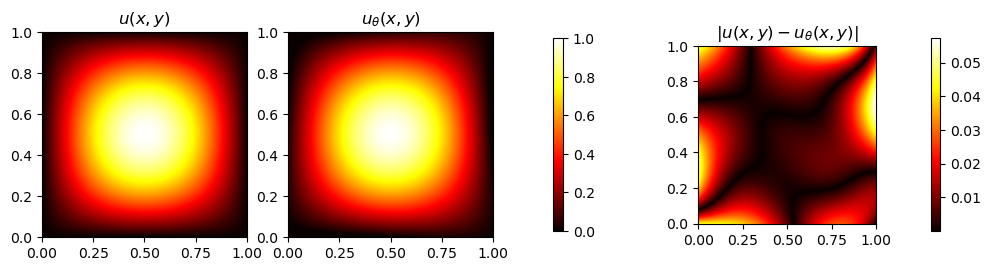

In [2]:
from util import save


n = 300
save("lra-gd", n, u_star, v_model, params)